In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Load and preprocess data

In [2]:
# Load and preprocess data
def prepare_data(df, feature_col='Open', seq_length=10):
    scaler = MinMaxScaler()
    df[feature_col] = scaler.fit_transform(df[[feature_col]])
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_col].iloc[i:i+seq_length].values)
        y.append(df[feature_col].iloc[i+seq_length])
    
    return np.array(X), np.array(y), scaler

## Load data

In [3]:
df = pd.read_csv("NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

## Prepare dataset

In [4]:
seq_length = 10  # Number of days for LSTM input
X, y, scaler = prepare_data(df, feature_col='Open', seq_length=seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM

# Convert to PyTorch tensors

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

## Train-Test-Validation Split

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Create DataLoader

In [8]:
batch_size = 16
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Define LSTM model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

## Initialize model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

## Define loss and optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

## Training loop with validation

In [12]:
epochs = 50
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


Epoch 1/50, Train Loss: 0.002352, Val Loss: 0.000449
Epoch 2/50, Train Loss: 0.000586, Val Loss: 0.000395
Epoch 3/50, Train Loss: 0.000318, Val Loss: 0.000147
Epoch 4/50, Train Loss: 0.000325, Val Loss: 0.000122
Epoch 5/50, Train Loss: 0.000244, Val Loss: 0.000076
Epoch 6/50, Train Loss: 0.000210, Val Loss: 0.000443
Epoch 7/50, Train Loss: 0.000345, Val Loss: 0.000276
Epoch 8/50, Train Loss: 0.000183, Val Loss: 0.000093
Epoch 9/50, Train Loss: 0.000255, Val Loss: 0.000069
Epoch 10/50, Train Loss: 0.000181, Val Loss: 0.000072
Epoch 11/50, Train Loss: 0.000213, Val Loss: 0.000121
Epoch 12/50, Train Loss: 0.000169, Val Loss: 0.000058
Epoch 13/50, Train Loss: 0.000166, Val Loss: 0.000047
Epoch 14/50, Train Loss: 0.000143, Val Loss: 0.000030
Epoch 15/50, Train Loss: 0.000167, Val Loss: 0.000349
Epoch 16/50, Train Loss: 0.000199, Val Loss: 0.000125
Epoch 17/50, Train Loss: 0.000159, Val Loss: 0.000029
Epoch 18/50, Train Loss: 0.000157, Val Loss: 0.000072
Epoch 19/50, Train Loss: 0.000112, Va

### Save model

In [31]:
# torch.save(model.state_dict(), "lstm_nvidia_model.pth")
torch.save(model.state_dict(), "lstm_nvidia_model2.pth")

## Plot training and validation loss

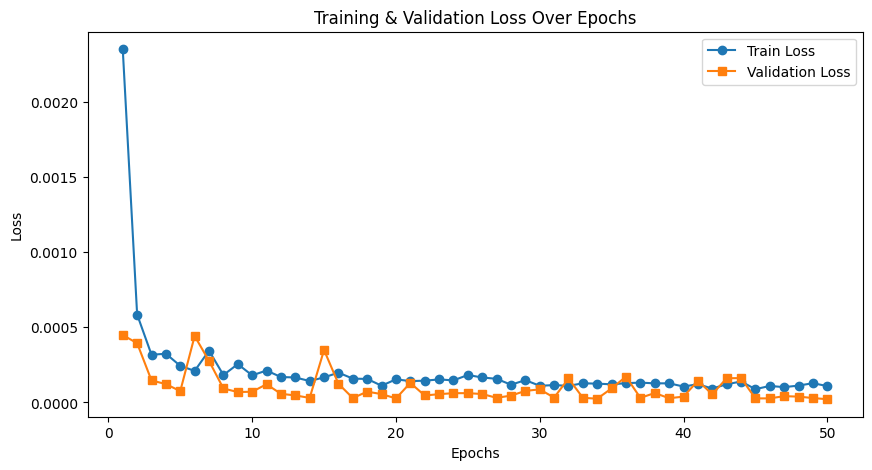

In [32]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()

## Load trained model

In [15]:

model.load_state_dict(torch.load(r"lstm_nvidia_model2.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Predictions

In [16]:
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

## Convert to original scale

In [17]:
predictions = scaler.inverse_transform(np.vstack(predictions))
actuals = scaler.inverse_transform(np.vstack(actuals))

## Plot actual vs predicted with transparency

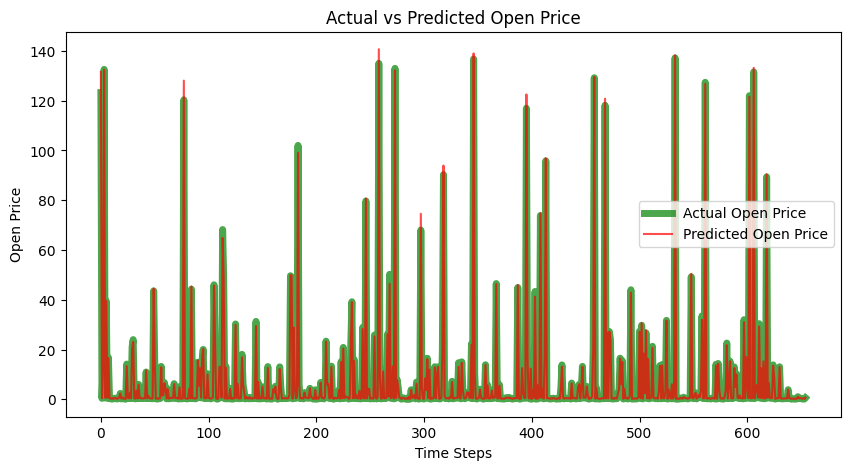

In [18]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.7,linewidth=5)  # Added alpha for transparency
plt.plot(predictions, label='Predicted Open Price', color='r', alpha=0.7)  # Added alpha for transparency
plt.legend()
plt.title("Actual vs Predicted Open Price")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

## Model evaluation

In [19]:
mse = np.mean((actuals - predictions) ** 2)
mae = np.mean(np.abs(actuals - predictions))
print(f"Test MSE: {mse:.6f}, Test MAE: {mae:.6f}")

Test MSE: 0.541415, Test MAE: 0.249050


## Identify failure cases

In [20]:
error_threshold = np.percentile(np.abs(actuals - predictions), 90)
failure_cases = np.where(np.abs(actuals - predictions) > error_threshold)[0]

## Failure Cases in Predictions

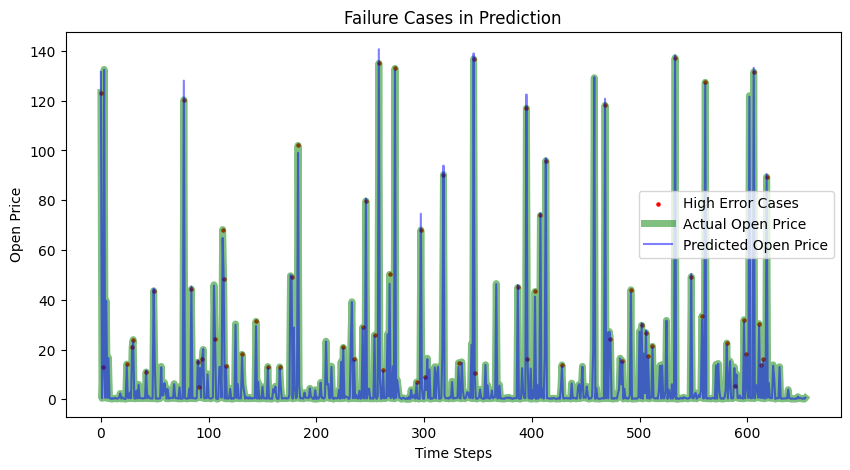

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(failure_cases, actuals[failure_cases], color='r', label='High Error Cases',s=5)
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.5, linewidth=5)
plt.plot(predictions, label='Predicted Open Price', color='b', alpha=0.5)
plt.legend()
plt.title("Failure Cases in Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

In [22]:
for idx in failure_cases:
    print(f"Failure Case {idx}:")
    print(f"Input Sequence: {X[idx]}")
    print(f"Actual: {actuals[idx]}, Predicted: {predictions[idx]}")

Failure Case 0:
Input Sequence: [[5.78711203e-05]
 [6.12764646e-05]
 [7.14859352e-05]
 [4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]]
Actual: [123.240005], Predicted: [131.53151]
Failure Case 2:
Input Sequence: [[7.14859352e-05]
 [4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]
 [3.82953369e-05]
 [4.34000754e-05]]
Actual: [12.88375], Predicted: [11.978295]
Failure Case 24:
Input Sequence: [[8.85126370e-05]
 [7.82966172e-05]
 [7.14859352e-05]
 [7.14859352e-05]
 [6.29758589e-05]
 [4.59557062e-05]
 [5.10604383e-05]
 [6.21261715e-05]
 [7.65972230e-05]
 [6.21261715e-05]]
Actual: [14.156999], Predicted: [13.312615]
Failure Case 29:
Input Sequence: [[4.59557062e-05]
 [5.10604383e-05]
 [6.21261715e-05]
 [7.65972230e-05]
 [6.21261715e-05]
 [5.61717260e-05]
 [5.61717260e-05]
 [6.29758589e-05]
 [5.44657825e-05]
 [5.44657825e-05]]
Actual: [21.10

## Persistence Model

In [34]:
# the persistence model (which predicts the next price to be the same as the last observed price)
#train, validation, and test MSE of persistence model
persistence_mse_train = np.mean((y_train.numpy() - X_train[:, -1, 0].numpy()) ** 2)
persistence_mse_val = np.mean((y_val.numpy() - X_val[:, -1, 0].numpy()) ** 2)
persistence_mse_test = np.mean((y_test.numpy() - X_test[:, -1, 0].numpy()) ** 2)
print(f"Persistence Model MSE - Train: {persistence_mse_train:.6f}, Validation: {persistence_mse_val:.6f}, Test: {persistence_mse_test:.6f}")
# Calculate the percentage of predictions that are within a certain threshold of the actual values
threshold = 0.05  # 5% threshold
within_threshold = np.mean(np.abs((predictions - actuals) / actuals) < threshold) * 100
print(f"Percentage of predictions within {threshold*100}% of actual values: {within_threshold:.2f}%")
# Calculate the percentage of predictions that are above a certain threshold
above_threshold = np.mean(predictions > actuals) * 100
print(f"Percentage of predictions above actual values: {above_threshold:.2f}%")
# Calculate the percentage of predictions that are below a certain threshold
below_threshold = np.mean(predictions < actuals) * 100
print(f"Percentage of predictions below actual values: {below_threshold:.2f}%")
# Calculate the percentage of predictions that are exactly equal to the actual values
equal_predictions = np.mean(predictions == actuals) * 100
print(f"Percentage of predictions exactly equal to actual values: {equal_predictions:.2f}%")
# Calculate the percentage of predictions that are within a certain range of the actual values
within_range = np.mean((predictions >= actuals - 0.1) & (predictions <= actuals + 0.1)) * 100
print(f"Percentage of predictions within range of actual values: {within_range:.2f}%")
# Calculate the percentage of predictions that are above the mean of actual values
above_mean = np.mean(predictions > np.mean(actuals)) * 100
print(f"Percentage of predictions above mean of actual values: {above_mean:.2f}%")

# Calculate the percentage of predictions that are below the mean of actual values
below_mean = np.mean(predictions < np.mean(actuals)) * 100
print(f"Percentage of predictions below mean of actual values: {below_mean:.2f}%")
# Calculate the percentage of predictions that are exactly equal to the mean of actual values
equal_mean = np.mean(predictions == np.mean(actuals)) * 100
print(f"Percentage of predictions exactly equal to mean of actual values: {equal_mean:.2f}%")
# Calculate the percentage of predictions that are within a certain range of the mean of actual values
within_mean_range = np.mean((predictions >= np.mean(actuals) - 0.1) & (predictions <= np.mean(actuals) + 0.1)) * 100
print(f"Percentage of predictions within range of mean of actual values: {within_mean_range:.2f}%")

Persistence Model MSE - Train: 0.052013, Validation: 0.034192, Test: 0.037786
Percentage of predictions within 5.0% of actual values: 28.85%
Percentage of predictions above actual values: 77.56%
Percentage of predictions below actual values: 22.44%
Percentage of predictions exactly equal to actual values: 0.00%
Percentage of predictions within range of actual values: 64.58%
Percentage of predictions above mean of actual values: 18.17%
Percentage of predictions below mean of actual values: 81.83%
Percentage of predictions exactly equal to mean of actual values: 0.00%
Percentage of predictions within range of mean of actual values: 0.00%


## Interpreting models using SHAP

SHAP (SHapley Additive exPlanations) is a framework for interpreting machine learning models by explaining the contribution of each feature to a model's predictions. It is based on Shapley values from cooperative game theory, which fairly distribute the "payout" (model prediction) among the "players" (features). 

Key features of SHAP:
1. **Global Interpretability**: It provides insights into which features are most important across the entire dataset.
2. **Local Interpretability**: It explains individual predictions by showing how each feature contributes positively or negatively to the output.
3. **Visualization Tools**: SHAP includes plots like summary plots, force plots, and dependence plots to make explanations intuitive and accessible.

SHAP is widely used for debugging, feature importance analysis, and ensuring transparency in machine learning models.

This cell is focused on visualizing and understanding the contributions of individual features to a specific prediction.

1. **Calculate the Expected Value**:  
   The model is set to evaluation mode using `model.eval()`, and the expected value of the model's predictions is calculated as the mean of the predictions on the training dataset (`X_train`). This value serves as the baseline for SHAP explanations.

2. **Generate Feature Names**:  
   A list of feature names is dynamically created based on the number of features in the flattened test dataset (`X_test_flat`). Each feature is labeled as "Feature 0", "Feature 1", etc.

3. **Create SHAP Explanation Object**:  
   The `shap.Explanation` object is constructed using the SHAP values (`shap_values[0]`), the calculated baseline (`expected_value`), the test data (`X_test_flat`), and the feature names. This object encapsulates all the information needed for SHAP visualizations.

4. **Generate Force Plot**:  
   The `shap.force_plot` function creates a force plot for a specific instance (e.g., the first instance in the test set). This plot visually explains how each feature contributes to the model's prediction for that instance. The `shap.initjs()` initializes JavaScript for rendering the plot in a Jupyter Notebook.

### For Failure Cases

In [26]:
X_failure = X[failure_cases]
y_failure_actual = y[failure_cases]
y_failure_pred = predictions[failure_cases]

In [27]:
import shap
from xgboost import train
model.eval()  # Ensure the model is in evaluation mode
# Ensure the input data has the correct shape (e.g., [batch_size, seq_length, num_features])
X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).to(device).view(-1, seq_length, 1)
X_failure_reshaped = torch.tensor(X_failure, dtype=torch.float32).to(device).view(-1, seq_length, 1)

# Initialize the SHAP explainer and compute SHAP values
model.train()
explainer = shap.GradientExplainer(model, X_train_reshaped)
model.train()
shap_values_failure = explainer.shap_values(X_failure_reshaped)

C:\Users\dheen\AppData\Local\Temp\ipykernel_28080\3631530211.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).to(device).view(-1, seq_length, 1)


In [28]:

model.eval()
expected_value = model(X_train_reshaped).mean().item()

# Flatten X_failure to 2D for shap.utils.hclust
X_failure_flat = X_failure_reshaped.view(X_failure_reshaped.shape[0], -1).cpu().numpy()

# Flatten shap_values_failure to match the shape of X_failure_flat
shap_values_failure_flat = np.array(shap_values_failure).reshape(len(failure_cases), -1)

# Convert shap_values into an Explanation object
shap_explanation = shap.Explanation(values=shap_values_failure_flat, base_values=expected_value, data=X_failure_flat)

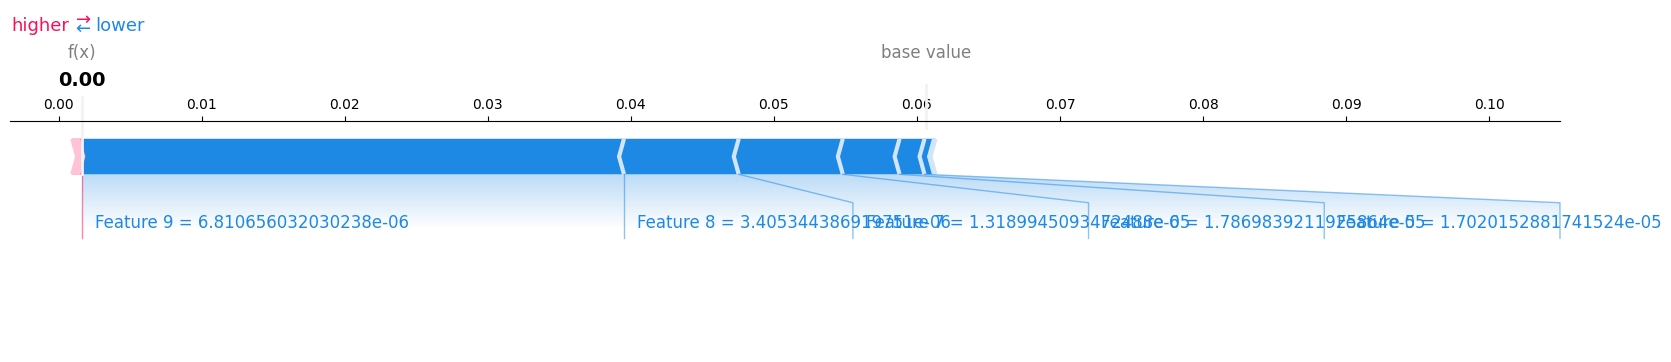

C:\Users\dheen\AppData\Local\Temp\ipykernel_28080\1769656871.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_failure_flat, X_failure_flat, plot_type="bar", show=True)


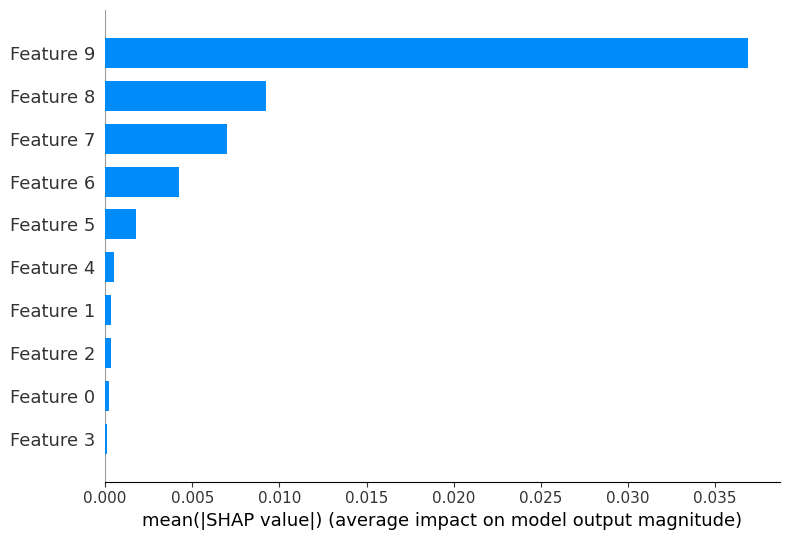

In [29]:
# Ensure the SHAP values and data are flattened to match dimensions
shap_values_flat = shap_explanation.values.reshape(shap_explanation.data.shape[0], -1)
data_flat = shap_explanation.data.reshape(shap_explanation.data.shape[0], -1)

feature_names_failure = [f"Feature {i}" for i in range(X_failure_flat.shape[1])]
shap_explanation.feature_names = feature_names_failure
# Generate the force plot for a specific instance (e.g., the 10th instance)
shap.force_plot(shap_explanation.base_values, shap_values_flat[10], 
                data_flat[10], feature_names = feature_names_failure, show=True, matplotlib=True)

#generate summary plot for failure cases
shap.summary_plot(shap_values_failure_flat, X_failure_flat, plot_type="bar", show=True)

C:\Users\dheen\AppData\Local\Temp\ipykernel_28080\18678913.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_failure_flat, X_failure_flat, show=True)


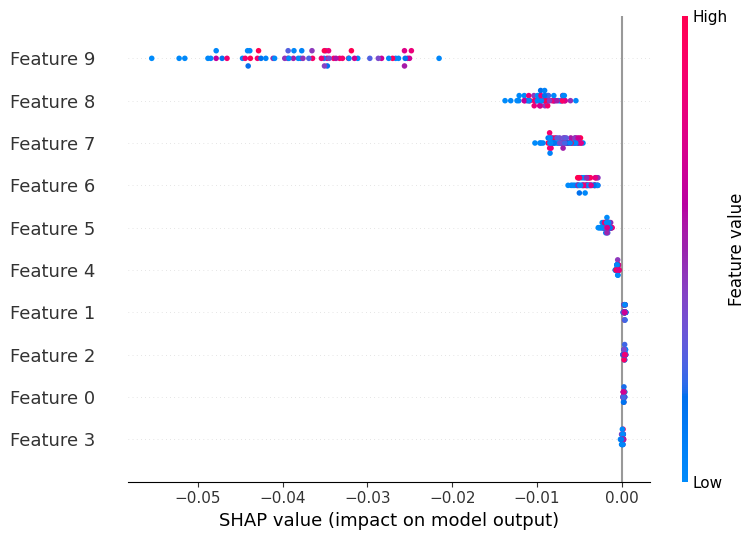

In [30]:
shap.summary_plot(shap_values_failure_flat, X_failure_flat, show=True)